In [1]:
from typing import List, Any, Dict
import json
import sys

import spacy
from spacy import displacy
from tqdm import tqdm
import numpy as np
import pandas as pd

from allennlp.data import DatasetReader, Instance
from allennlp.data.dataset_readers.dataset_utils.span_utils import bio_tags_to_spans
from allennlp.models.archival import load_archive
from allennlp.predictors import Predictor

sys.path.append('..')
import defx  # register custom classes

In [2]:
dev_file_path = '/home/huebner/code/semeval_2020_task_6/data/deft_split/jsonl/dev.jsonl'
model_file_path = '/home/huebner/research/semeval_2020_task_6/experiments/2020-02-10__repeated_subtask2_models/repeated_subtask2_crf_bert/run_0_2020-02-07_15-43-01ho2f9ecl/trial/model.tar.gz'
predictor = Predictor.from_path(model_file_path, 'subtask1_predictor')

In [3]:
dev_instances = predictor._dataset_reader.read(dev_file_path)

734it [00:00, 2705.37it/s]


In [4]:
def tokens_to_text(tokens):
    text = ''
    char_offsets = []
    for token in tokens:
        start_offset = len(text)
        text += token
        end_offset = len(text)
        char_offsets.append((start_offset, end_offset))
        text += ' '
    return text, char_offsets

In [5]:
def spans_to_spacy(spans, char_offsets):
    displacy_ents = []
    for span in spans:
        char_start = char_offsets[span[1][0]][0]
        char_end = char_offsets[span[1][1]][1]
        displacy_ents.append({
            'label': span[0],
            'start': char_start,
            'end': char_end
        })
    return displacy_ents

def displacy_example(tokens, tags):
    text, char_offsets = tokens_to_text(tokens)
    spans = bio_tags_to_spans(tags)
    spans = sorted(spans, key=lambda x: x[1][0])
    displacy_ents = spans_to_spacy(spans, char_offsets)
    displacy_output = {
        'text': text,
        'ents': displacy_ents,
        'title': None
    }
    colors = {
        'TERM': 'lightgreen',
        'DEFINITION': 'lightblue',
    }
    displacy.render(displacy_output, style='ent', manual=True, options={"colors": colors})
    
def displacy_instance(instance):
    tokens = [t.text for t in instance.fields['tokens']]
    tags = instance.fields['tags']
    displacy_example(tokens, tags)
    
def displacy_prediction(prediction):
    tokens = prediction['words']
    tags = prediction['tags']
    displacy_example(tokens, tags)

In [6]:
displacy_instance(dev_instances[0])

In [7]:
def batched_predict_instances(predictor, examples: List[Instance]) -> List[Dict[str, Any]]:
    results = []  # type: List[Dict[str, Any]]
    batch_size = 10
    for i in tqdm(range(0, len(examples), batch_size)):
        batch_examples = examples[i: i + batch_size]
        batch_results = predictor.predict_batch_instance(batch_examples)
        results.extend(batch_results)
    return results

In [8]:
dev_predictions = batched_predict_instances(predictor, dev_instances)

100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


In [9]:
diffs = []
for instance, prediction in zip(dev_instances, dev_predictions):
    gold_tags = instance.fields['tags']
    pred_tags = prediction['tags']
    if list(gold_tags) != pred_tags:
        diffs.append((instance, prediction))

In [10]:
def show_comparison(instance, prediction):
    print('*' * 100)
    displacy_instance(instance)
    print('*' * 100)
    displacy_prediction(prediction)
    print('*' * 100)

In [11]:
diff_iterator = iter(diffs)

In [37]:
diff = next(diff_iterator)
show_comparison(*diff)

****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


In [19]:
def plot_substring_dist(prediction, search_string):
    label_index = list(predictor._model.vocab.get_index_to_token_vocabulary(namespace='labels').values())
    text, char_offsets = tokens_to_text(prediction['words'])
    start_char = text.find(search_string)
    end_char = start_char + len(search_string)
    start_token_idx = [c[0] for c in char_offsets].index(start_char)
    end_token_idx = [c[1] for c in char_offsets].index(end_char)
    for token_idx in range(start_token_idx, end_token_idx+1):
        current_word = prediction['words'][token_idx]
        arr = np.array(prediction['logits'][token_idx])
        probs = np.exp(arr)/sum(np.exp(arr))
        pd.DataFrame(probs, index=label_index).plot.bar(title=current_word)

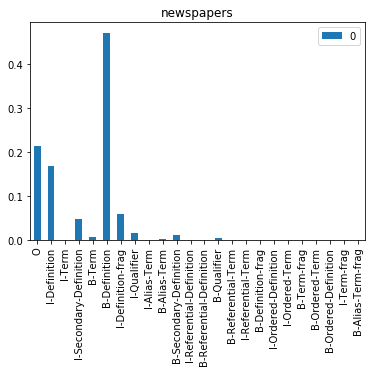

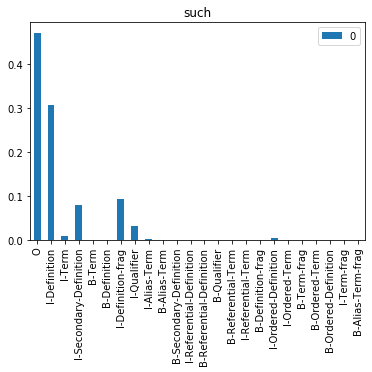

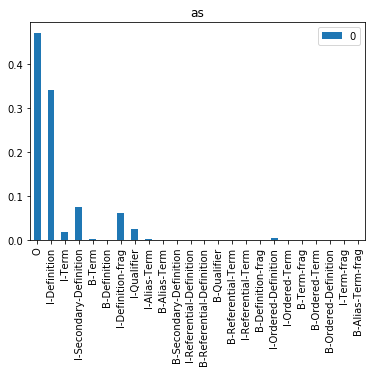

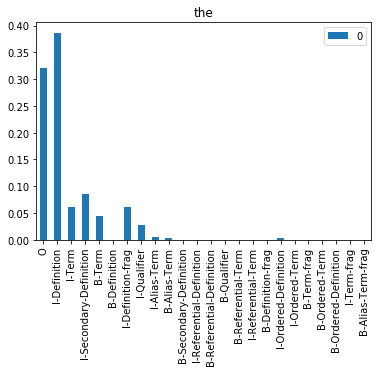

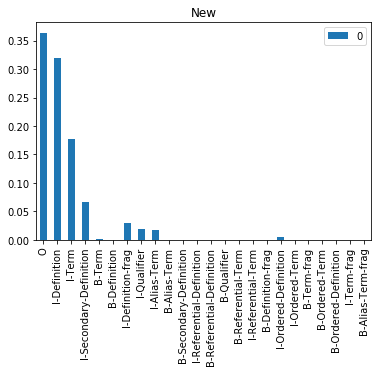

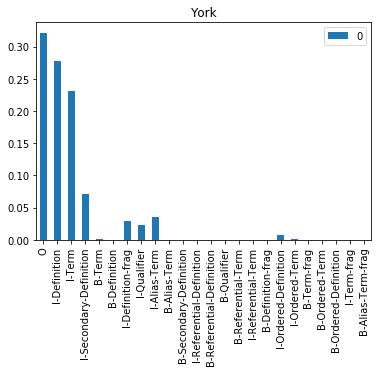

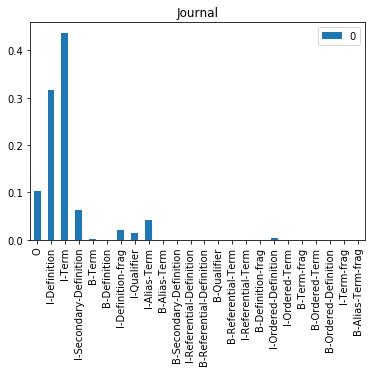

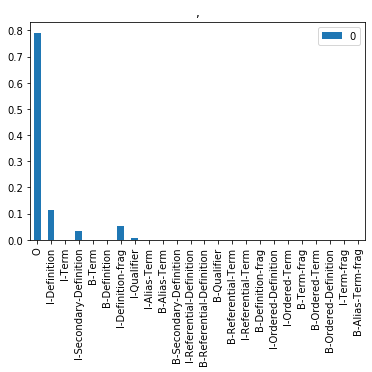

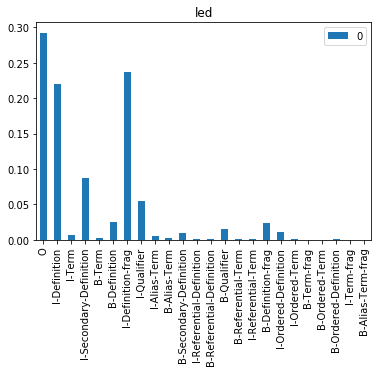

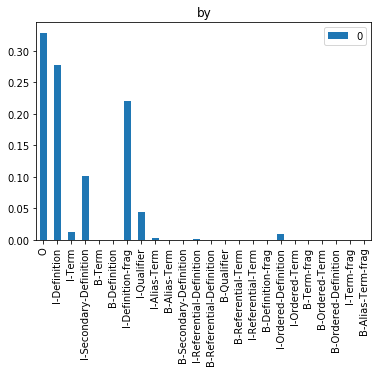

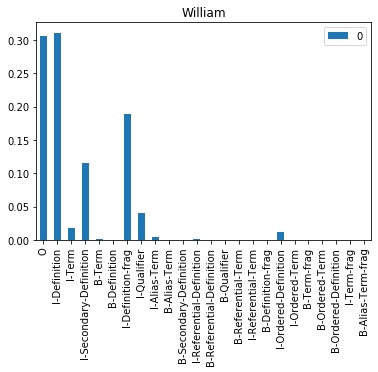

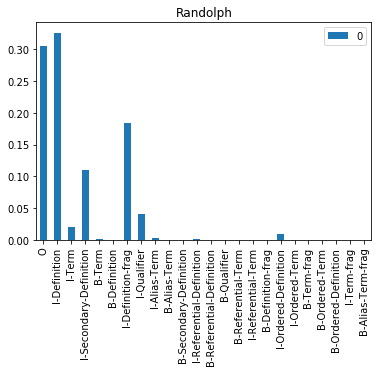

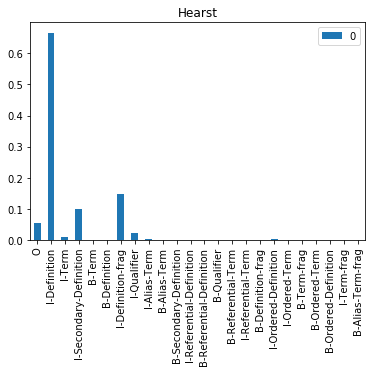

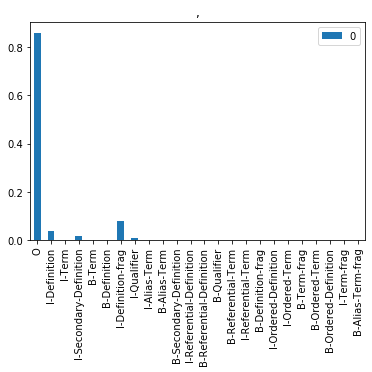

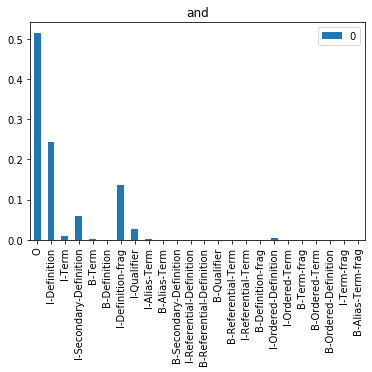

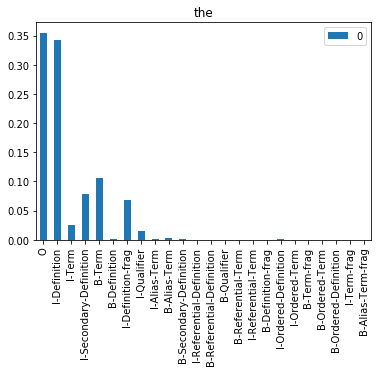

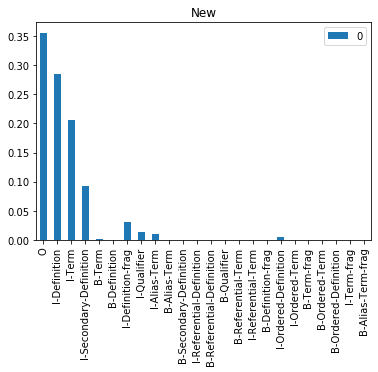

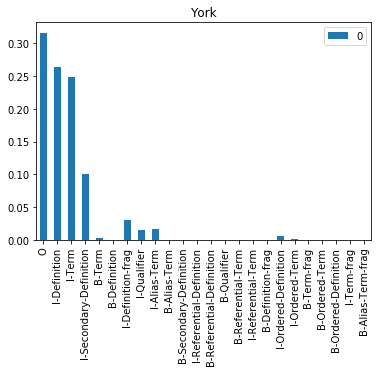

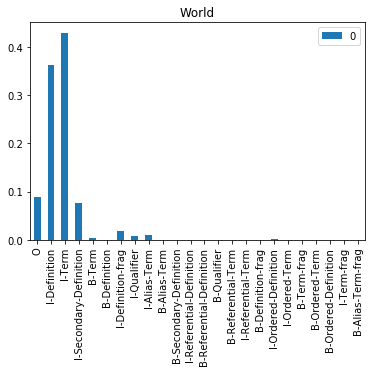

In [33]:
plot_substring_dist(diff[1], "newspapers such as the New York Journal , led by William Randolph Hearst , and the New York World")